In [4]:
cd /home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src

/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src


In [5]:
import os
import sys

sys.path.insert(0, os.path.abspath("./post_processing/local_calculations"))
sys.path.insert(0, os.path.abspath("./helper_functions/cloud"))
sys.path.insert(0, os.path.abspath("./file_manager"))
sys.path.insert(0, os.path.abspath("./hamiltonian_builder"))
sys.path.insert(0, os.path.abspath("./correlation"))
sys.path.insert(0, os.path.abspath("./single_and_double_excitations_subspace"))

In [6]:
from qutip import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from hamiltonian.hamiltonian_builder import *
from helper_functions.operators import *
from helper_functions.cloud import *
from correlation.second_order_correlation  import *
from single_and_double_excitations_subspace.parameter_generator_for_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_ODE import *
from post_processing.local_calculations import *
from helper_functions.cloud import *

from file_manager.visualization_preparation_tools import *
from file_manager.file_saver import *

In [ ]:
N_atoms = N = 5
b0 = 0.1

r = random_cloud(0, N, exc_radius = None, b0 = b0)


Omega = 2
Delta = 20
tf = 20
t_span, dt = np.linspace(0,tf,100, retstep = True) 

In [ ]:
Beta1D_time_list, Beta2D_time_list, t_span, r = SolveForBeta1DandBeta2D(N_atoms, kd = None, b0 = None, exc_radius = None, Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, interaction = True, r = r, t_span = t_span  );

In [ ]:
%timeit
S_H, S_c_ops, GTensor,M, GammaSR, DeltaSR, Omega, SR_state, r = system_spec_N(1, N_atoms, kd = None, b0 = None, exc_radius = None , Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, r = r)
rho_ss_S, total_time_ss = get_steadystate(S_H, 0, r,  0, S_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)

In [ ]:
S_sigmam_i_expectations = np.zeros(len(r), dtype = "object")
S_sigmam_ij_expectations = np.zeros((len(r),len(r)), dtype = "object")

V_sigmam_i_expectations = np.zeros(len(r), dtype = "object")
V_sigmam_ij_expectations = np.zeros((len(r),len(r)), dtype = "object")


for i in range(len(r)):
    S_sigmam_i_expectations[i] = expect(rho_ss_S, sigmam_i(N, i))

    for j in range(len(r)):
        S_sigmam_ij_expectations[i][j] = expect(rho_ss_S, sigmam_i(N, i)*sigmam_i(N, j))

        

# Second Correlation Function

In [4]:
def get_theta_zero_both_methods(N, Omega, Delta,ang1, R2):
    
    
    taulist = np.array([0])
    nhat = 1


    ang1 = 25
    R1 = get_nhat_from_angle(ang1)

    #ang2 = np.linspace(0, 360, 100)
    ang2 = np.insert(np.linspace(0, 360, 100), 57, 205)
    
    R2_list = [] 
    g2_zero_exact = []
    g2_zero_approximated = []
    V_g2_zero_exact = []

    N_atoms = N

    r = random_cloud(0, N, exc_radius = None, b0 = b0)
    S_H, S_c_ops, GTensor,M, GammaSR, DeltaSR, Omega, SR_state, r = system_spec_N(1, N_atoms, kd = None, b0 = b0, exc_radius = None , Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, r = r, beam = "plane_wave")
    rho_ss_S, total_time_ss = get_steadystate(S_H, 0, r,  b0, S_c_ops, N, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)


    tf = 20
    t_span, dt = np.linspace(0,tf,100, retstep = True) 
    Delta1D, Omega1D, Gamma2D, Delta2D  = GetAllODEParametersGiven_r(Omega, Delta, r, scalar = True)
    Beta1D_time_list, Beta2D_time_list, t_span, r = SolveForBeta1DandBeta2D(N_atoms, kd = None, b0 = None, exc_radius = None, Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, interaction = True, r = r, t_span = t_span  );

    for theta in ang2:
            #sys.stdout.write("\r{0}".format(theta))
            #sys.stdout.flush()

            R2 = get_nhat_from_angle(theta)
            R2_list.append(get_nhat_from_angle(theta))

            G2_ls, normalization_ls, rho_ss, total_time_ss, total_time_correlation = g2_l(S_H, 0, r, R1, R2, taulist, S_c_ops, N, faseglobal = 1, rho_ss = rho_ss_S, rho_ss_parameter = "direct", tmax = None)
            g2_i = G2_ls/normalization_ls

            g2_zero_exact.append(g2_i)

            #g2_i = g2_l(V_H, nhat, r, R1, R2, taulist, V_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)[0]        
            #V_g2_zero_exact.append(g2_i)

            g2_i = np.real(g2_of_zero_subspace_approach(r, R1, R2, Beta1D_time_list[-1], Beta2D_time_list[-1]))
            g2_zero_approximated.append(g2_i)
            
    return np.hstack(g2_zero_exact), np.array(g2_zero_approximated)


In [ ]:
experiments = 20

N_atoms = N = 5
b0 = 7.01

Omega = 2
Delta = 20


description = f"b0_{b0}_S_Int_On_avg_testing_benchmarking_fixing_g2zero_by_angle_with_montecarlo"
path_to_save_file = get_path_to_save_files(N, Omega, Delta,  description)                                                                
filename ="{4}/N{3}_Omega{5}_Delta{6}_run".format(25,205,0,N,path_to_save_file, Omega, Delta) 
for i in range(experiments):
    g2_exact, g2_MonteCarlo = get_theta_zero_both_methods(N, Omega, Delta,25, 0)
    run_number = get_new_run_number_dat(filename)
    name_of_file =  "{4}/N{3}_Omega{5}_Delta{6}_run{2}".format(25,205,run_number,N, path_to_save_file, Omega, Delta)
    np.save(name_of_file, [g2_exact, g2_MonteCarlo])
    print(name_of_file)
    

In [7]:
#N = 5
#Omega = 0.1

experiments = 20

N_atoms = N = 5
b0 = 2

Omega = 2
Delta = 20
description = f"b0_{b0}_S_Int_On_avg_testing_benchmarking_fixing_g2zero_by_angle_with_montecarlo"


results_path = "../results/"
DefaultInfo = f"N{N}_Omega{Omega}_Delta{Delta}_"
defaultangle, angle = "25_", "205"
rho_ss_parameter = "_direct"


label_folder = results_path+DefaultInfo+description + "/" # "_"+ defaultangle +angle+ "_"   + rho_ss_parameter + "/"
paths_array = get_array_of_runs_dat_files(label_folder) #all runs for a given phi
runs_txt = get_array_of_numpy_runs(paths_array, npy = True)

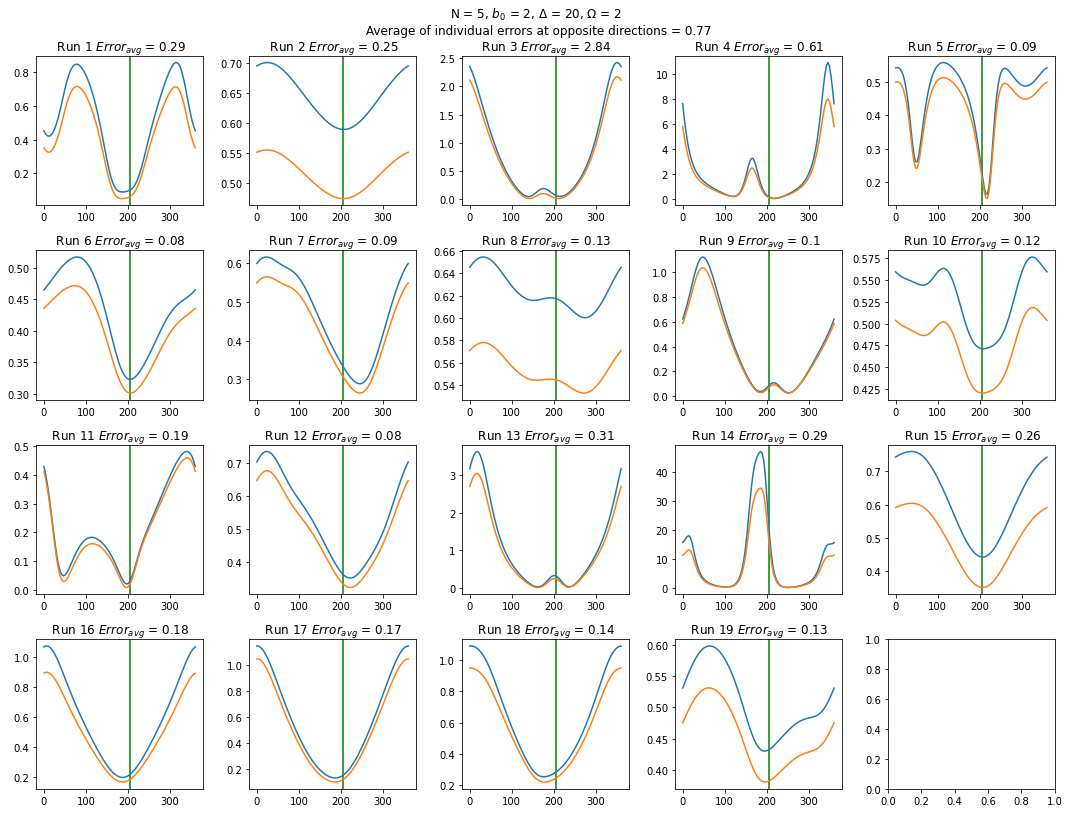

In [10]:
fig = plt.figure(figsize = (15,14))


ang2 = np.insert(np.linspace(0, 360, 100), 57, 205)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

error_at_opposite_directions_list = [] 


rows = 5
columns = 5
initial = 0

indexes_to_plot = list(range(initial, initial + rows*columns+1,1))
for j in range(1,rows*columns+1):
    plt.subplot(rows, columns, j)#harey= plt.subplot(551))
    
    l = indexes_to_plot[j]
    try:
        avg_relative_error = np.average(np.abs(1 - np.real(runs_txt[l])[0]/np.real(runs_txt[l][1])))
    except:
        break
    #plt.title(f" Run {l}:"+ r"$<1-g^{(2)}_{MC}/g^{(2)}_{qutip}>$"+ f"= {np.round(avg_relative_error, 2)}. ", loc = "left") 
    index_of_opposite_directions =  57
    error_at_opposite_directions = np.round(np.abs(1 - np.real(runs_txt[l])[0]/np.real(runs_txt[l][1]))[index_of_opposite_directions], 2)
    error_at_opposite_directions_list.append(error_at_opposite_directions)
    
    plt.axvline(205, color = "green")
    plt.title(f" Run {l}" + " $Error_{avg}$" + f" = {np.round(avg_relative_error, 2)} ") 
    plt.plot( ang2, np.real(runs_txt[l][0])) #g2 Exact 
    plt.plot( ang2, np.real(runs_txt[l][1])) #g2 MonteCarlo
    #plt.ylim(0,1)
    #plt.text(0.7,  0.80, r"Error at $\theta_{2} = 205^o$"+ f" = {error_at_opposite_directions}",
            #bbox=props)

plt.suptitle(f"N = {N}, $b_0$ = {b0}, $\Delta$ = {Delta}, $\Omega$ = {Omega} \n Average of individual errors at opposite directions = {np.round(np.average(error_at_opposite_directions_list), 2)}")


plt.tight_layout()
plt.savefig(f"./benchmarking/N{N}_Omega{Omega}_Delta_{Delta}_b0_{b0}_qutip_vs_MC_g2zero_error_{rows}x{columns}.png", dpi = 300)

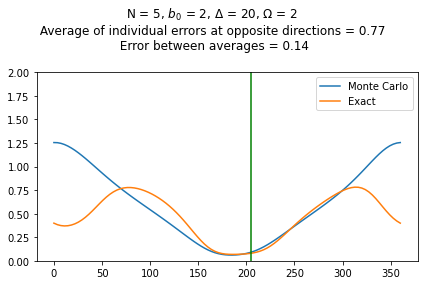

In [27]:
plt.plot( ang2, gmean(runs_txt, axis = 1)[0], label = "Monte Carlo")
plt.plot( ang2, gmean(runs_txt, axis = 1)[1], label = "Exact")
error_between_averages = np.abs(1-gmean(runs_txt, axis = 1)[0][57]/gmean(runs_txt, axis = 1)[1][57])
plt.suptitle(f"N = {N}, $b_0$ = {b0}, $\Delta$ = {Delta}, $\Omega$ = {Omega} \n Average of individual errors at opposite directions = {np.round(np.average(error_at_opposite_directions_list), 2)} \n Error between averages = {np.round(np.average(error_between_averages), 2)}")
plt.axvline(205, color = "green")
plt.ylim(0,2)

plt.legend()
plt.tight_layout()
plt.savefig(f"./benchmarking/N{N}_Omega{Omega}_Delta_{Delta}_b0_{b0}_qutip_vs_MC_g2zero_error_for_averages.png", dpi = 300)

In [25]:
np.average(error_at_opposite_directions_list)

0.7699999999999999

In [ ]:
np.abs(1-gmean(runs_txt, axis = 1)[0][index_of_opposite_directions]/gmean(runs_txt, axis = 1)[1][index_of_opposite_directions])